In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import losses
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, AveragePooling2D, Dropout, BatchNormalization, Activation,MaxPooling1D, add, Embedding, Conv1D
from tensorflow.keras.preprocessing.text import Tokenizer  
from keras.preprocessing import sequence
import matplotlib.pyplot as plt
import datetime
from tensorflow.keras.regularizers import l2
from keras import backend as K
from bs4 import BeautifulSoup
import re
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing The Data

train_df = pd.read_csv('https://github.com/odedovadia/AdvancedMLDLCourse/blob/main/Assignments/Assignment%20III/train.csv?raw=true')
test_df = pd.read_csv('https://github.com/odedovadia/AdvancedMLDLCourse/blob/main/Assignments/Assignment%20III/test.csv?raw=true')

print('Shape of train is:', train_df.shape)
print('Shape of test is:', test_df.shape)

Shape of train is: (70405, 5)
Shape of test is: (4245, 5)


Taking the dialogue only for training purpose

In [ ]:
x_train = train_df['Dialogue']
y_train = train_df['Show']

print('Shape of X_train is:', x_train.shape)
print('Shape of Y_test is:', y_train.shape)

Shape of X_train is: (70405,)
Shape of Y_test is: (70405,)


In [ ]:
x_test = test_df['Dialogue']
y_test = test_df['Show']

print('Shape of X_train is:', x_test.shape)
print('Shape of Y_test is:', y_test.shape)

Shape of X_train is: (4245,)
Shape of Y_test is: (4245,)


Taking a glimpse from our train and test datasets

In [ ]:
pd.DataFrame([x_train[0:10],y_train[0:10]])

,0,1,2,3,4,5,6,7,8,9
Dialogue,Hey.,(to Joey) Are you gonna be embarrassed going ...,"Me? No no no, you. You're gonna tell him. I'm ...",Alright you guys are off to party number one ...,Am I? Or am I so sane that you just blew your ...,"So, if you’re parents hadn’t got divorced, yo...",What's up?,"(over-enthusiastic) I don't know, I don' I do...",I know. *He* always wanted to be the first bl...,"This uniform, what's it made from?"
Show,Friends,Friends,Seinfeld,Friends,Seinfeld,Friends,Friends,Friends,Friends,Seinfeld


In [ ]:
pd.DataFrame([x_test[0:10],y_test[0:10]])


,0,1,2,3,4,5,6,7,8,9
Dialogue,"Oh my God, that's great! I'm smart!! No, no, ...","Listen, I’m sure that dad doesn’t care. He pr...",Well I am. Couldn't you try to go through some...,Yes I am. We had a verbal contract. If we can'...,"Um, I straightened out your shower curtain so...","You guys, I'm telling you, when she runs, she...",Really?! So what would you say Pheebs? Stuff ...,"Mom, there are so many people in my life. Som...",All right listen ball boys! My grandmother ha...,"(to himself) A cane. I knew it. (to Neil) So, ..."
Show,Friends,Friends,Seinfeld,Seinfeld,Friends,Friends,Friends,Friends,Friends,Seinfeld


In [ ]:
print("Train Samples:")
print(y_train.value_counts()) # Check how many samples we have in the train

print("Test Samples:")
print(y_test.value_counts()) # Check how many samples we have in the test

Train Samples:
Friends     39092
Seinfeld    31313
Name: Show, dtype: int64
Test Samples:
Friends     2596
Seinfeld    1649
Name: Show, dtype: int64


We can tell that "Friends" got more dialogues in the show hence more data available

In [ ]:
print("Percentage of 'Friends' samples in the train:")
print(y_train.value_counts()[0]/(y_train.value_counts()[0]+y_train.value_counts()[1]))
print("Percentage of 'Friends' samples in the test:")
print(y_test.value_counts()[0]/(y_test.value_counts()[0]+y_test.value_counts()[1]))

Percentage of 'Friends' samples in the train:
0.5552446559193239
Percentage of 'Friends' samples in the test:
0.6115429917550059


The balance is not perfect but we have enough samples from both classes.

Matching our test length

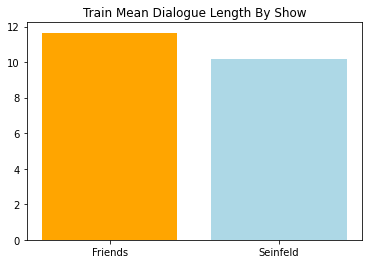

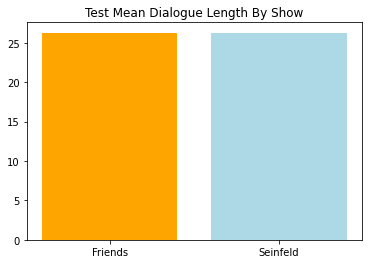

In [ ]:
grouped_data = train_df.groupby('Show')['Dialogue_length'].mean()
show_names = grouped_data.index
dialogue_lengths = grouped_data.values
plt.bar(show_names, dialogue_lengths, color=['orange', 'lightblue'])
plt.title('Train Mean Dialogue Length By Show')
plt.show()

grouped_data = test_df.groupby('Show')['Dialogue_length'].mean()
show_names = grouped_data.index
dialogue_lengths = grouped_data.values
plt.bar(show_names, dialogue_lengths, color=['orange', 'lightblue'])
plt.title('Test Mean Dialogue Length By Show')
plt.show()

The mean value between the shows seems pretty equal, but the mean length in the test set is twice bigger!

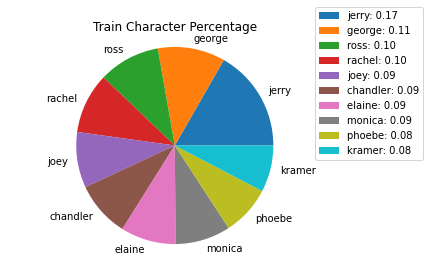

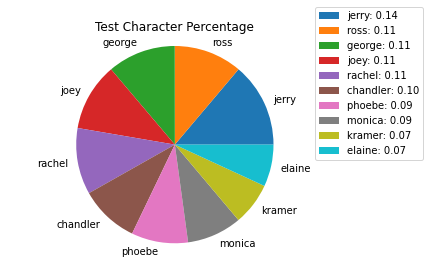

In [ ]:
character_counts = train_df['Character'].value_counts()
character_names = character_counts.index
character_counts = character_counts.values
character_percentages = character_counts / train_df.shape[0]
plt.pie(character_percentages, labels=character_names)
labels = [f'{name}: {percentage:.2f}' for name, percentage in zip(character_names, character_percentages)]
plt.legend(labels, bbox_to_anchor=(1.1,1), loc="upper right", bbox_transform=plt.gcf().transFigure)
plt.axis('equal')
plt.title('Train Character Percentage')
plt.show()

character_counts = test_df['Character'].value_counts()
character_names = character_counts.index
character_counts = character_counts.values
character_percentages = character_counts / test_df.shape[0]
plt.pie(character_percentages, labels=character_names)
labels = [f'{name}: {percentage:.2f}' for name, percentage in zip(character_names, character_percentages)]
plt.legend(labels, bbox_to_anchor=(1.1,1), loc="upper right", bbox_transform=plt.gcf().transFigure)
plt.axis('equal')
plt.title('Test Character Percentage')
plt.show()

The distribution between the characters seems about right and equal between the train and test data sets.


Before we start we will fixate the random state

In [ ]:
# Set seed in order to maintain the same models and results
tf.random.set_seed(1234)

We ain't dealing with text generation, only with classification between "Seinfeld" and "Friends". <br> Therefore, to reduce dimensionality we'll get rid of all special characters.

In [ ]:
# Define function for removing special characters
def remove_special_characters(text):
    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern,'',text)
    return text

# Define function for convert characters to lower case
def to_lower_case(text):
  text = text.lower()
  return text

# Remove all sentences between parentheses
def remove_parentheses(text):
  text = re.sub(r'\([^)]*\)', '', text)
  return text

# Combine those three functions to handle characters and parentheses
def characters_handling(text):
  text = remove_special_characters(text)
  text = to_lower_case(text)
  text = remove_parentheses(text)
  return text

# Apply function on train
x_train = x_train.apply(characters_handling)



In [ ]:
pd.DataFrame([x_train[0:10],y_train[0:10]])

,0,1,2,3,4,5,6,7,8,9
Dialogue,hey,to joey are you gonna be embarrassed going up...,me no no no you youre gonna tell him im not go...,alright you guys are off to party number one ...,am i or am i so sane that you just blew your mind,so if youre parents hadnt got divorced youd b...,whats up,overenthusiastic i dont know i don i don know...,i know he always wanted to be the first black...,this uniform whats it made from
Show,Friends,Friends,Seinfeld,Friends,Seinfeld,Friends,Friends,Friends,Friends,Seinfeld


Removing Stop Words

In [ ]:
nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('english')
print('Number of English stop words:', len(stopword_list))
print(stopword_list[:10])

Number of English stop words: 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Tokenize the dialogues

In [ ]:
tokenizer = ToktokTokenizer()

Examine the tokenizer

In [ ]:
tokenizer.tokenize(x_train[1])

['to',
 'joey',
 'are',
 'you',
 'gonna',
 'be',
 'embarrassed',
 'going',
 'up',
 'there',
 'having',
 'nothing',
 'prepared']

In [ ]:
# Removing the stopwords
from tqdm.notebook import tqdm # Help us to visualize in what state the process is while using a bar
tqdm.pandas()

# Define function for removing stop words
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

# Apply function on x_train

x_train = x_train.progress_apply(remove_stopwords)
x_train[0:10]

  0%|          | 0/70405 [00:00<?, ?it/s]

0                                                  hey
1        joey gonna embarrassed going nothing prepared
2                   youre gonna tell im gonna tell noo
3    alright guys party number one ushers 3 guys mo...
4                                       sane blew mind
5    youre parents hadnt got divorced youd able ans...
6                                                whats
7    overenthusiastic dont know know trying get you...
8    know always wanted first black man cross atlantic
9                                   uniform whats made
Name: Dialogue, dtype: object

Lemmatization using spaCy or word net lemmatization

In [ ]:
import spacy
!python -m spacy download en

nlp = spacy.load("en_core_web_sm")

# Define function for lemmatize words
def spacy_lemmatizer(text):
  # Tokenize
  doc = nlp(text)
  lemmas = [token.lemma_ for token in doc]
  lemmatized_text = ' '.join(lemmas) # Turn the words back to a sentence
  return lemmatized_text

x_train = x_train.progress_apply(spacy_lemmatizer)
x_train[0:3]


/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-01-03 14:07:45.325431: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 26.6 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


  0%|          | 0/70405 [00:00<?, ?it/s]

0                                          hey
1    joey go to embarrassed go nothing prepare
2         you re go to tell I m go to tell noo
Name: Dialogue, dtype: object

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42, stratify = y_train) # Split to train and validation sets

In [ ]:
Y_train_binary = Y_train.replace({'Friends': 0, 'Seinfeld': 1})
Y_val_binary = Y_val.replace({'Friends': 0, 'Seinfeld': 1})
y_test_binary = y_test.replace({'Friends': 0, 'Seinfeld': 1})

Test data pre-process

In [ ]:
x_test = x_test.progress_apply(characters_handling)
x_test = x_test.progress_apply(remove_stopwords)
x_test = x_test.progress_apply(spacy_lemmatizer)


  0%|          | 0/4245 [00:00<?, ?it/s]

  0%|          | 0/4245 [00:00<?, ?it/s]

  0%|          | 0/4245 [00:00<?, ?it/s]

Verify our data sets shapes

In [ ]:
print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_val shape:', X_val.shape)
print('Y_val shape:', Y_val.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (63364,)
Y_train shape: (63364,)
X_val shape: (7041,)
Y_val shape: (7041,)
x_test shape: (4245,)
y_test shape: (4245,)


Now we will use keras tokenizer

In [ ]:
token = Tokenizer(lower=False)
token.fit_on_texts(X_train)

In [ ]:
X_train[0]

'hey'

Convert to sequences

In [ ]:
x_train_dl = token.texts_to_sequences(X_train)
x_val_dl = token.texts_to_sequences(X_val)
x_test_dl = token.texts_to_sequences(x_test)

In [ ]:
x_train_dl[0]

[4, 17, 11, 159, 246, 2478, 34, 9331, 420, 41, 16, 270, 2479]

Explore dialogues length

In [ ]:
dialogue_len_list = [len(dialogue) for dialogue in x_train_dl]

In [ ]:
print("max dialogue length (words) is: ", max(dialogue_len_list))
print("min dialogue length (words) is: ", min(dialogue_len_list))
print("mean dialogue length (words) is: ", np.mean(dialogue_len_list))


max dialogue length (words) is:  205
min dialogue length (words) is:  0
mean dialogue length (words) is:  6.3415504071712645


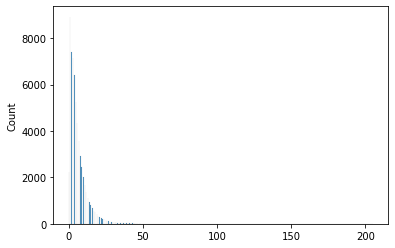

In [ ]:
ax = sns.histplot(dialogue_len_list)
plt.show()

Let's zoom in a little bit

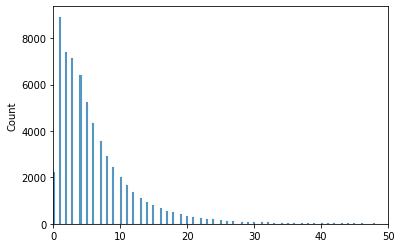

In [ ]:
bx = sns.histplot(dialogue_len_list)
bx.set_xlim(0, 50)
plt.show()

In [ ]:
dialogues_36_plus = sum([1 for x in dialogue_len_list if x > 35])
print("Number of dialogues that are longer than 35 words: ", dialogues_36_plus)
print("Percentage of dialogues that are longer than 35 words: ", dialogues_36_plus/len(x_train_dl))

Number of dialogues that are longer than 35 words:  423
Percentage of dialogues that are longer than 35 words:  0.006675714916987564


Check if the pre-process left us with some uninformative dialogues. <br>
If so, we might want to ignore them when we train our model.

In [ ]:
dialogues_empty = sum([1 for x in dialogue_len_list if x < 1])
print("Number of empty dialogues: ", dialogues_empty)
print("Percentage of empty dialogues: ", dialogues_empty/len(x_train_dl))

Number of empty dialogues:  2214
Percentage of empty dialogues:  0.0349409759484881


In [ ]:
max_words = 36

x_train_dl_cut = tf.keras.preprocessing.sequence.pad_sequences(x_train_dl, maxlen=max_words)
x_val_dl_cut = tf.keras.preprocessing.sequence.pad_sequences(x_val_dl, maxlen=max_words)
x_test_dl = tf.keras.preprocessing.sequence.pad_sequences(x_test_dl, maxlen=max_words)

Verify changes

In [ ]:
x_train_dl_cut.shape

(63364, 36)

In [ ]:
x_val_dl_cut.shape

(7041, 36)

In [ ]:
x_test_dl.shape

(4245, 36)

In [ ]:
dialogue_len_list_cut = [len(dialogue) for dialogue in x_train_dl_cut]
print("max dialogue length (words) is: ", max(dialogue_len_list_cut))
print("min dialogue length (words) is: ", min(dialogue_len_list_cut))
print("mean dialogue length (words) is: ", np.mean(dialogue_len_list_cut))

max dialogue length (words) is:  36
min dialogue length (words) is:  36
mean dialogue length (words) is:  36.0


Check how our samples looks like now

In [ ]:
x_train_dl_cut[80, :]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4, 24, 18,
       15, 32], dtype=int32)

Let's check how many words we have in our vocabulary

In [ ]:
total_words = len(token.word_index) + 1 
total_words

18838

Callbacks

In [ ]:
save_model = ModelCheckpoint(
    filepath='/content/drive/My Drive/Colab Notebooks/EX3/model3',
    save_best_only=True,
    monitor='val_loss',
    verbose=1,
    mode='min'
)


reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.6,
    patience=5
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=10**-7,
    patience=9,
    verbose=1, 
    mode='min',
    restore_best_weights=True
)

callbacks = [save_model, reduce_lr, early_stop]

MODELS

In [ ]:
from keras.layers import GRU
rnn_model = Sequential()
rnn_model.add(Embedding(input_dim=total_words, output_dim= 16, input_length=max_words))
rnn_model.add(GRU(128))
rnn_model.add(Dropout(0.4))
rnn_model.add(Dense(64, activation='relu'))
rnn_model.add(Dropout(0.4))
rnn_model.add(Dense(1, activation='sigmoid'))
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 36, 16)            301408    
                                                                 
 gru (GRU)                   (None, 128)               56064     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 365,793
Trainable params: 365,793
Non-trai

In [ ]:
rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
rnn_model.fit(x_train_dl_cut, Y_train_binary, validation_data=(x_val_dl_cut, Y_val_binary), epochs=15, batch_size=64, callbacks=callbacks)


Epoch 1/15
990/991 [============================>.] - ETA: 0s - loss: 0.5384 - accuracy: 0.6927
Epoch 1: val_loss improved from inf to 0.48729, saving model to /content/drive/My Drive/Colab Notebooks/EX3/model3


991/991 [==============================] - 65s 61ms/step - loss: 0.5384 - accuracy: 0.6927 - val_loss: 0.4873 - val_accuracy: 0.7303 - lr: 0.0010
Epoch 2/15
991/991 [==============================] - ETA: 0s - loss: 0.4466 - accuracy: 0.7642
Epoch 2: val_loss improved from 0.48729 to 0.47749, saving model to /content/drive/My Drive/Colab Notebooks/EX3/model3


991/991 [==============================] - 47s 48ms/step - loss: 0.4466 - accuracy: 0.7642 - val_loss: 0.4775 - val_accuracy: 0.7385 - lr: 0.0010
Epoch 3/15
991/991 [==============================] - ETA: 0s - loss: 0.4114 - accuracy: 0.7827
Epoch 3: val_loss did not improve from 0.47749
991/991 [==============================] - 45s 45ms/step - loss: 0.4114 - accuracy: 0.7827 - val_loss: 0.4883 - val_accuracy: 0.7392 - lr: 0.0010
Epoch 4/15
990/991 [============================>.] - ETA: 0s - loss: 0.3825 - accuracy: 0.7970
Epoch 4: val_loss did not improve from 0.47749
991/991 [==============================] - 43s 43ms/step - loss: 0.3824 - accuracy: 0.7970 - val_loss: 0.5147 - val_accuracy: 0.7346 - lr: 0.0010
Epoch 5/15
991/991 [==============================] - ETA: 0s - loss: 0.3631 - accuracy: 0.8063
Epoch 5: val_loss did not improve from 0.47749
991/991 [==============================] - 43s 43ms/step - loss: 0.3631 - accuracy: 0.8063 - val_loss: 0.5291 - val_accuracy: 0.7361 

In [ ]:
loss_train_rnn, acc_train_rnn = rnn_model.evaluate(x_train_dl_cut, Y_train_binary)

1981/1981 [==============================] - 15s 8ms/step - loss: 0.3919 - accuracy: 0.7997


Train accuracy

In [ ]:
print("Train accuracy score:", "{:.3f}".format(acc_train_rnn))

Train accuracy score: 0.800


In [ ]:
loss_test_rnn, acc_test_rnn = rnn_model.evaluate(x_test_dl, y_test_binary)

133/133 [==============================] - 1s 8ms/step - loss: 0.3352 - accuracy: 0.8424


Test accuracy

In [ ]:
print("Test accuracy score:", "{:.4f}".format(acc_test_rnn))

Test accuracy score: 0.8424


We tried different size of embedding and "max_words" per dialogue and we got the best results under this values. Although it is common to choose an embedding layer with a dimension of 100-300, it might be due to limited amount of data and not too many words in it, our model like to keep it simple and use a smaller vector. 

### Examine Results

133/133 [==============================] - 1s 7ms/step


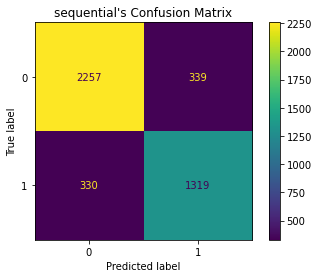

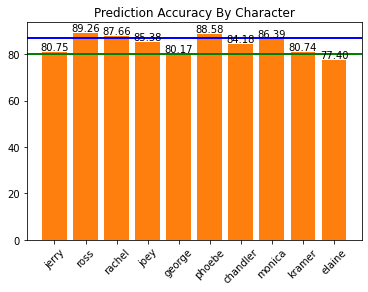


	Green Line - Seinfeld Accuracy: 79.99
	Blue Line - Friends Accuracy: 86.94


In [ ]:
# Plot Model's Confusion Matrix
predictions = rnn_model.predict(x_test_dl)
predicted_labels = np.where(predictions >= 0.5, 1, 0).reshape(1,-1).tolist()[0]
true_labels = y_test_binary.tolist()
class_labels = [0, 1]
cm = confusion_matrix(true_labels, predicted_labels, labels=class_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot()
plt.title(rnn_model.name + "'s Confusion Matrix")
plt.show()

# Plot Prediction accuracy By Character
chracters_acc = np.where(np.abs(np.array(predicted_labels) - np.array(true_labels)) == 0)
character_counts = (test_df.loc[chracters_acc,'Character'].value_counts())
character_names = character_counts.index
c_p = {}
for c in character_names:
  character_app = test_df[test_df['Character'] == c].shape[0]
  c_p[c] = round((float(int(character_counts[c])/int(character_app)))* 100,2)
fig, ax = plt.subplots()
rects = ax.bar(range(len(c_p.values())), c_p.values())
for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height, '%.2f' % height, ha='center', va='bottom')
plt.bar(c_p.keys(), c_p.values())
plt.title('Prediction Accuracy By Character')
ax.set_xticklabels(c_p.keys(), rotation=45)
se_acc = (cm.diagonal()/cm.sum(axis=1))[1]*100
fr_acc = (cm.diagonal()/cm.sum(axis=1))[0]*100
ax.axhline(fr_acc, color='blue', linewidth=2)
ax.axhline(se_acc, color='green', linewidth=2)
plt.show()
print('\n\tGreen Line - Seinfeld Accuracy: ' + str(round(se_acc,2)))
print('\tBlue Line - Friends Accuracy: ' + str(round(fr_acc,2)))




***Report our results per show***

In [ ]:
print("Seinfeld accuracy:", se_acc)
print("Friends accuracy:", fr_acc)

Seinfeld accuracy: 79.98787143723469
Friends accuracy: 86.94144838212635


***Report our results per character***

In [ ]:
print("Seinfeld characters accuracy:")

print("\nJerry's accuracy:", c_p['jerry'])
print("Elaine's accuracy:", c_p['elaine'])
print("George's accuracy:", c_p['george'])
print("Kramer's accuracy:", c_p['kramer'])

print("\nFriends characters accuracy:", fr_acc)

print("\nRachel's accuracy:", c_p['rachel'])
print("Ross's accuracy:", c_p['ross'])
print("Monica's accuracy:", c_p['monica'])
print("Chandler's accuracy:", c_p['chandler'])
print("Joey's accuracy:", c_p['joey'])
print("Phoebe's accuracy:", c_p['phoebe'])

Seinfeld characters accuracy:

Jerry's accuracy: 80.75
Elaine's accuracy: 77.4
George's accuracy: 80.17
Kramer's accuracy: 80.74

Friends characters accuracy: 86.94144838212635

Rachel's accuracy: 87.66
Ross's accuracy: 89.26
Monica's accuracy: 86.39
Chandler's accuracy: 84.18
Joey's accuracy: 85.38
Phoebe's accuracy: 88.58


We can tell we had much more success with "Friends" dialogues. <br>
It might be because we had more data on this show, it might be because they actually easier to identify or it might be beacuse of our model :) <br>
But overall the score is satisfying

In [ ]:
pred_model_test = rnn_model.predict(x_test_dl, verbose=1)
pred_model_test_labels = np.round(pred_model_test)
model_test_score = accuracy_score(y_test_binary ,pred_model_test_labels)

133/133 [==============================] - 1s 7ms/step


In [ ]:
pred_model_train = rnn_model.predict(x_train_dl_cut, verbose=1)
pred_model_train_labels = np.round(pred_model_train)
model_train_score = accuracy_score(Y_train_binary ,pred_model_train_labels)

1981/1981 [==============================] - 15s 7ms/step


In [ ]:
seinfeld_script = train_df['Dialogue'][train_df['Show'] == 'Seinfeld']
seinf_train = x_train.loc[seinfeld_script.index.tolist()]
longest_dialogue_seinfeld = seinf_train.apply(lambda x: len(x.split())).idxmax()

In [ ]:
friends_script = train_df['Dialogue'][train_df['Show'] == 'Friends']
friends_train = x_train.loc[friends_script.index.tolist()]
longest_dialogue_friends = friends_train.apply(lambda x: len(x.split())).idxmax()

Let's see how Seinfeld longest dialogue looks like using WordCloud

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

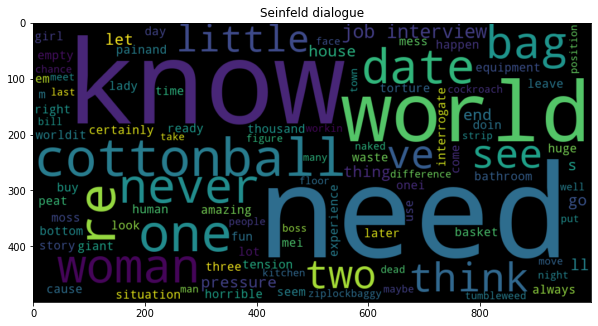

In [ ]:
plt.figure(figsize=(10, 10))
plt.title('Seinfeld dialogue')
seinfeld_text = x_train[longest_dialogue_seinfeld]
WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
positive_words = WC.generate(seinfeld_text)
plt.imshow(positive_words, interpolation='bilinear')
plt.show()

And Friends longest dialogue


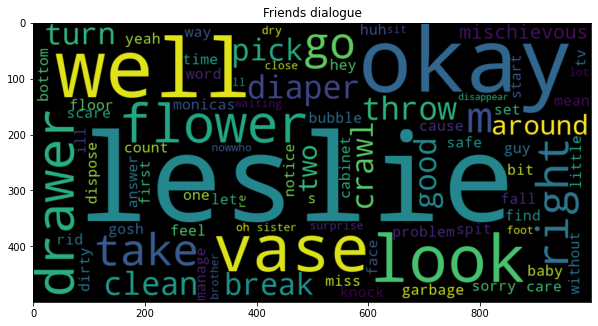

In [ ]:
plt.figure(figsize=(10, 10))
plt.title('Friends dialogue')
friends_text = x_train[longest_dialogue_friends]
WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
positive_words = WC.generate(friends_text)
plt.imshow(positive_words, interpolation='bilinear')
plt.show()

In [ ]:
results = {'model': ['RNN Model'],
           'Test score (Accuracy)': ["{:.4f}".format(model_test_score)],
           'Train score (Accuracy)': ["{:.3f}".format(model_train_score)],
           'Number of trainable parameters': ["365,793"],
           'Number of layers': [len(rnn_model.layers)],
           'Regularization methods': ['Dropout'],
           'Number of epochs': [11],
           'Loss function': ['binary crossentropy'],
           'Optimizer': ['adam'],
           'Embedding dimension': [16]
           }

df = pd.DataFrame(results)
df

,model,Test score (Accuracy),Train score (Accuracy),Number of trainable parameters,Number of layers,Regularization methods,Number of epochs,Loss function,Optimizer,Embedding dimension
0,RNN Model,0.8424,0.800,"365,793",6,Dropout,11,binary crossentropy,adam,16


In [ ]:
df.to_csv(os.path.join(os.getcwd(), 'exercise3.csv'))
df.to_csv("/content/drive/My Drive/Colab Notebooks/EX3/exercise3.csv")